# Inits

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import pickle
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib

# Organizing, scaling data for ML methods
All columns not relating to predicting score (INCLUDING non-normalized distance from TSS) are dropped in the creation of the training and test sets

## Reading in data

In [2]:
read_df = pd.read_csv("structured_set.csv")

# filter out all columns that only have a singular value in them
df = read_df.loc[:, read_df.nunique() > 1]

X = df.drop(columns = ["score", 
                       "gene", 
                       "chromosome",
                       "PAM_coord",
                       "strand targeted", 
                       "sequence", 
                       "transcript", 
                       "strand", 
                       "TSS source",
                       "prim_TSS_5p",
                       "prim_TSS_3p",
                       "sec_TSS_5p",
                       "sec_TSS_3p",
                       "norm_prim_TSS_dist5p",
                       "norm_prim_TSS_dist3p",
                       "norm_sec_TSS_dist5p",
                       "norm_sec_TSS_dist3p",
                       "struct"])
y = df.loc[:, "score"]

## Preprocessing

In [3]:
stan = StandardScaler()
stan_cols = ["prim_TSS_dist5p", "prim_TSS_dist3p", "sec_TSS_dist5p", "sec_TSS_dist3p", "length", "GC_content", "GA_content", "CA_content", "frac_A", "frac_C", "frac_T", "frac_G"]

minmax = MinMaxScaler()
minmax_cols = ["longest_A", "longest_C", "longest_T", "longest_G", "1_MMs", "2_MMs", "3_MMs", "mfe"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# applying scaling AFTER splitting - this is so the training and test set are scaled relative to their own set
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[stan_cols] = stan.fit_transform(X_train_scaled[stan_cols])
X_train_scaled[minmax_cols] = minmax.fit_transform(X_train_scaled[minmax_cols])
X_test_scaled[stan_cols] = stan.transform(X_test_scaled[stan_cols])
X_test_scaled[minmax_cols] = minmax.transform(X_test_scaled[minmax_cols])

In [4]:
imp_title = (["unimportant"] * 4) + ["length"] + (["unimportant"] * 13) + (["TSS_distance"] * 4) + (["ACTG_composition"] * 4) + (["dimer_composition"] * 3) + (["ACTG_pos"] * (4 * 25)) + \
    (["dimer_pos"] * ((4 ** 2) * 25)) + (["OT"] * 3) + ["unimportant"] + ["mfe"] + (["secondary_struct"] * 25 * 3) + (["longest_ACTG"] * 4)
imp_series = pd.Series(imp_title)
mask = read_df.nunique() > 1
imp_series = imp_series[mask.values]
imp_title = imp_series[imp_series != "unimportant"]

# Support Vector Regression

## Fitting model

In [5]:
from sklearn.svm import SVR

# svr = SVR(kernel = "rbf")

# params = {
#     "C": Real(0.0001, 1000, prior = "log-uniform"),
#     "gamma": Real(1e-9, 0.1, prior = "log-uniform"),
# }

# grid_svr = BayesSearchCV(svr, params, scoring = "neg_mean_squared_error", n_iter = 50, cv = 5, n_points = 2, verbose = 1)
# grid_svr.fit(X_train_scaled, y_train)
# best_svr = grid_svr.best_estimator_
# with open("models/SVR.pk1", "wb") as file:
#     pickle.dump(grid_svr.best_estimator_, file)
    
with open("models/SVR.pk1", "rb") as file:
    best_svr = pickle.load(file)

## Comparing model fit with test set

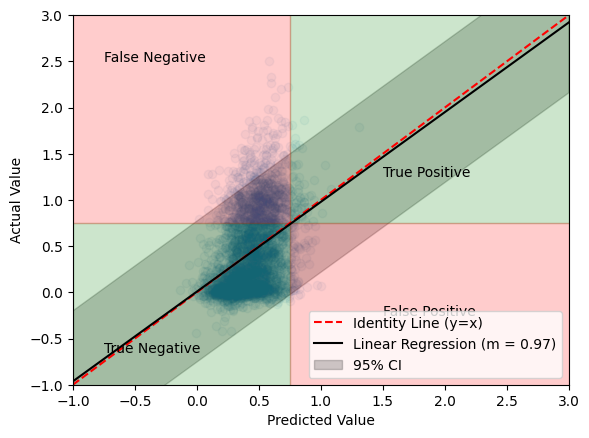

In [52]:
y_pred = best_svr.predict(X_test_scaled)

threshold = 0.75 # threshold by where we consider an sgRNA to be "highly active"
xmin = -1 # minimum on x axis
xmax = 3 # maximum on x axis
x = np.linspace(xmin, xmax, 100)

# fitting a linear regression to the data
lin_reg = LinearRegression()
lin_reg.fit(y_pred.reshape(-1, 1), y_test)
slope = lin_reg.coef_[0] # perfect fit, slope = 1
intercept = lin_reg.intercept_ # perfect fit, intercept = 0
y_pred_lr = lin_reg.predict(x.reshape(-1, 1))

# getting error bar for the linear regression
residuals = y_pred - lin_reg.predict(np.array(y_test).reshape(-1, 1))
std_res = np.std(residuals)
ci = 1.96 * std_res
lower_ci = y_pred_lr - ci
upper_ci = y_pred_lr + ci

xdist = (threshold - xmin) / (xmax - xmin) # distance along the x axis to place the location of threshold
plt.scatter(y_pred, y_test, alpha = 0.05)
plt.plot(x, x, color = 'red', linestyle = '--', label = 'Identity Line (y=x)')
plt.plot(x, lin_reg.predict(x.reshape(-1, 1)), color = "black", label = f"Linear Regression (m = {round(slope, 2)})") # plotting linear regression
plt.fill_between(x, lower_ci, upper_ci, color = "black", alpha = 0.2, label = "95% CI")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.axhspan(-5, threshold, color = "green", alpha = 0.2, xmax = xdist) # true negative
plt.axhspan(threshold, 5, color = "green", alpha = 0.2, xmin = xdist) # true positive
plt.axhspan(-5, threshold, color = "red", alpha = 0.2, xmin = xdist) # false positive
plt.axhspan(threshold, 5, color = "red", alpha = 0.2, xmax = xdist) # false negative
plt.text(1.5, 1.25, "True Positive")
plt.text(-0.75, -0.65, "True Negative")
plt.text(1.5, -0.25, "False Positive")
plt.text(-0.75, 2.5, "False Negative")
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.legend()
plt.show()

## ROC curve (and other metrics)

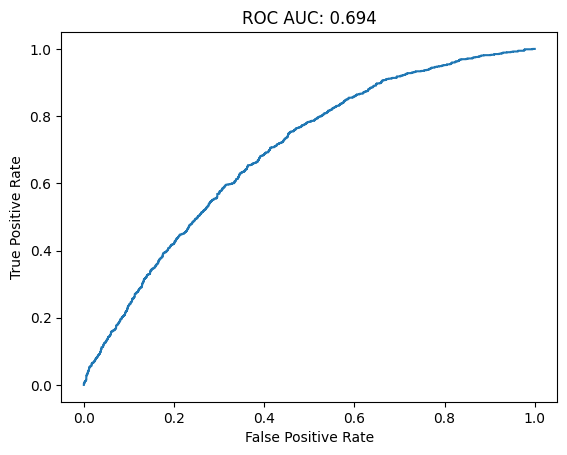

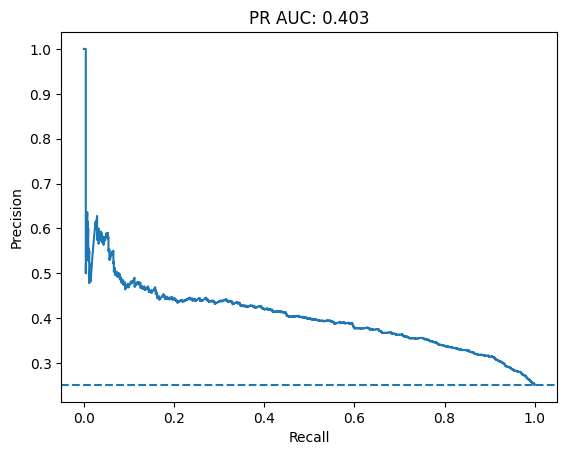

F1 score:  0.12927756653992395


In [7]:
actual_pos = df["score"] >= threshold
y_prob = y_test >= threshold
prevalence = np.sum(y_prob) / len(y_prob)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_prob, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# precision-recall curve
precision, recall, threshholds = precision_recall_curve(y_prob, y_pred)
roc_pr = auc(recall, precision)

plt.figure()
plt.title("PR AUC: " + str(round(roc_pr, 3)))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axhline(prevalence, linestyle = "--")
plt.show()

# f1 score
f1 = f1_score(y_prob, y_pred >= threshold)
print("F1 score: ", f1)

# Random Forest Regression
Gilbert and his lab used elastic net linear regression - I tried this, but it just wasn't working. Random forest offers a more robust analysis and cares less about the scale of the features, but is more black box and harder to interpret.

## Fitting model

In [10]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()

params = {
    "n_estimators": Integer(1, 500),
    "max_depth": Integer(1, 100),
    "min_samples_leaf": Real(0.0001, 0.9999, prior = "log-uniform")
}

grid_rf_reg = BayesSearchCV(rf_reg, params, scoring = "neg_mean_squared_error", n_iter = 30, n_jobs = -1, cv = 5, n_points = 5, verbose = 1)
_ = grid_rf_reg.fit(X_train_scaled, y_train)
best_rf_reg = grid_rf_reg.best_estimator_
joblib.dump(grid_rf_reg.best_estimator_, "models/RF.joblib", compress = ("lzma", 3))

# best_rf_reg = joblib.load("models/RF.joblib")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


['models/RF.joblib']

## Comparing model fit with test set

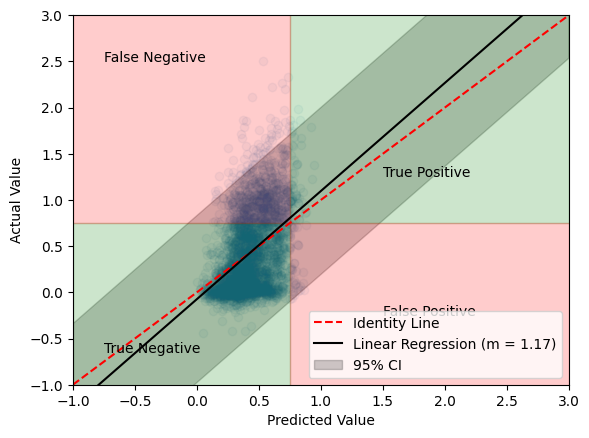

In [36]:
y_pred = best_rf_reg.predict(X_test_scaled)

threshold = 0.75 # threshold by where we consider an sgRNA to be "highly active"
xmin = -1 # minimum on x axis
xmax = 3 # maximum on x axis
x = np.linspace(xmin, xmax, 100)

# fitting a linear regression to the data
lin_reg = LinearRegression()
lin_reg.fit(y_pred.reshape(-1, 1), y_test)
slope = lin_reg.coef_[0] # perfect fit, slope = 1
intercept = lin_reg.intercept_ # perfect fit, intercept = 0
y_pred_lr = lin_reg.predict(x.reshape(-1, 1))

# getting error bar for the linear regression
residuals = y_pred - lin_reg.predict(np.array(y_test).reshape(-1, 1))
std_res = np.std(residuals)
ci = 1.96 * std_res
lower_ci = y_pred_lr - ci
upper_ci = y_pred_lr + ci

xdist = (threshold - xmin) / (xmax - xmin) # distance along the x axis to place the location of threshold
plt.scatter(y_pred, y_test, alpha = 0.05)
plt.plot(x, x, color = 'red', linestyle = '--', label = 'Identity Line')
plt.plot(x, lin_reg.predict(x.reshape(-1, 1)), color = "black", label = f"Linear Regression (m = {round(slope, 2)})") # plotting linear regression
plt.fill_between(x, lower_ci, upper_ci, color = "black", alpha = 0.2, label = "95% CI")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.axhspan(-5, threshold, color = "green", alpha = 0.2, xmax = xdist) # true negative
plt.axhspan(threshold, 5, color = "green", alpha = 0.2, xmin = xdist) # true positive
plt.axhspan(-5, threshold, color = "red", alpha = 0.2, xmin = xdist) # false positive
plt.axhspan(threshold, 5, color = "red", alpha = 0.2, xmax = xdist) # false negative
plt.text(1.5, 1.25, "True Positive")
plt.text(-0.75, -0.65, "True Negative")
plt.text(1.5, -0.25, "False Positive")
plt.text(-0.75, 2.5, "False Negative")
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.legend()
plt.show()

## ROC curve (and other metrics)

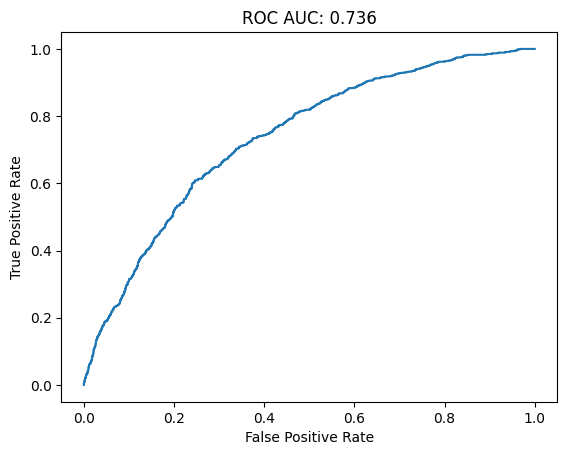

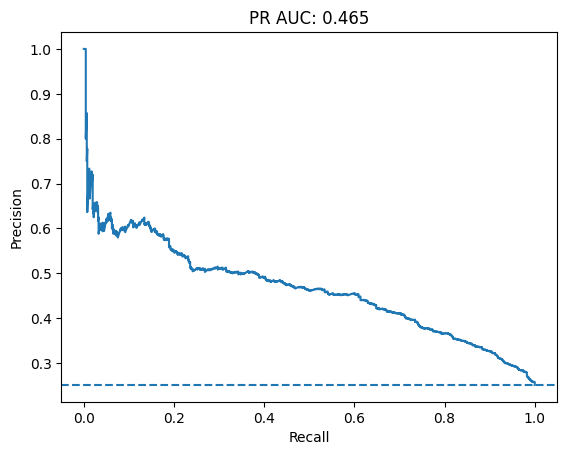

F1 score:  0.11648568608094768


In [13]:
actual_pos = df["score"] >= threshold
y_prob = y_test >= threshold
prevalence = np.sum(y_prob) / len(y_prob)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_prob, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# precision-recall curve
precision, recall, threshholds = precision_recall_curve(y_prob, y_pred)
roc_pr = auc(recall, precision)

plt.figure()
plt.title("PR AUC: " + str(round(roc_pr, 3)))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axhline(prevalence, linestyle = "--")
plt.show()

# f1 score
f1 = f1_score(y_prob, y_pred >= threshold)
print("F1 score: ", f1)

## Feature importances

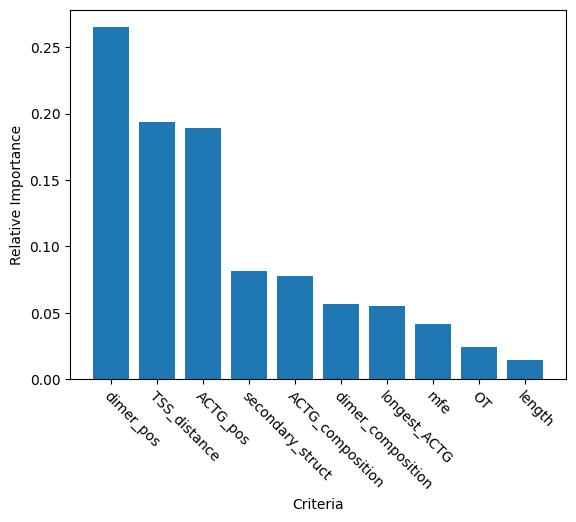

In [15]:
feature_imps = best_rf_reg.feature_importances_
sum_imps = feature_imps.sum()
imp_df = pd.DataFrame({
    "title": imp_title,
    "importance": feature_imps / sum_imps
})
grouped_imp_df = imp_df.groupby("title").sum().reset_index().sort_values(by = "importance", ascending = False)

plt.figure()
plt.bar(grouped_imp_df["title"], grouped_imp_df["importance"])
plt.xticks(rotation = -45, ha = "left", rotation_mode = "anchor")
plt.xlabel("Criteria")
plt.ylabel("Relative Importance")
plt.show()

# Light Gradient Boosting Regression
Allegedly more robust than random forest regression.

## Fitting model

In [38]:
from lightgbm import LGBMRegressor

# lgbm_reg = LGBMRegressor(verbose = 0, reg_lambda = 1)

# params = {
#     "n_estimators": Integer(50, 500),
#     "learning_rate": Real(0.001, 0.3, prior = "log-uniform"),
#     "num_leaves": Integer(2, 100),
#     # "reg_lambda": Real(0, 1),
#     "reg_alpha": Real(0, 1),
# }

# grid_lgbm_reg = BayesSearchCV(lgbm_reg, params, scoring = "r2", n_iter = 30, cv = 5, n_points = 2, verbose = 1)
# _ = grid_lgbm_reg.fit(X_train_scaled, y_train)
# best_lgbm_reg = grid_lgbm_reg.best_estimator_
# with open("models/LGBM.pk1", "wb") as file:
#     pickle.dump(best_lgbm_reg, file)
    
with open("models/LGBM.pk1", "rb") as file:
    best_lgbm_reg = pickle.load(file)

## Comparing model fit with test set

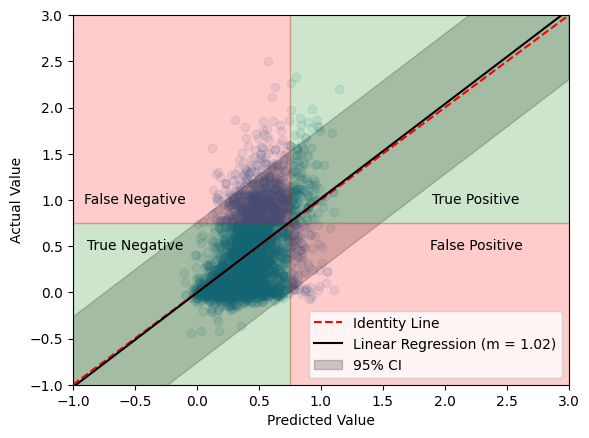

In [65]:
y_pred = best_lgbm_reg.predict(X_test_scaled)

threshold = 0.75 # threshold by where we consider an sgRNA to be "highly active"
xmin = -1 # minimum on x axis
xmax = 3 # maximum on x axis
x = np.linspace(xmin, xmax, 100)

# fitting a linear regression to the data
lin_reg = LinearRegression()
lin_reg.fit(y_pred.reshape(-1, 1), y_test)
slope = lin_reg.coef_[0] # perfect fit, slope = 1
intercept = lin_reg.intercept_ # perfect fit, intercept = 0
y_pred_lr = lin_reg.predict(x.reshape(-1, 1))

# getting error bar for the linear regression
residuals = y_pred - lin_reg.predict(np.array(y_test).reshape(-1, 1))
std_res = np.std(residuals)
ci = 1.96 * std_res
lower_ci = y_pred_lr - ci
upper_ci = y_pred_lr + ci

xdist = (threshold - xmin) / (xmax - xmin) # distance along the x axis to place the location of threshold
plt.scatter(y_pred, y_test, alpha = 0.1)
plt.plot(x, x, color = 'red', linestyle = '--', label = 'Identity Line')
plt.plot(x, y_pred_lr, color = "black", label = f"Linear Regression (m = {round(slope, 2)})") # plotting linear regression
plt.fill_between(x, lower_ci, upper_ci, color = "black", alpha = 0.2, label = "95% CI")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.axhspan(-5, threshold, color = "green", alpha = 0.2, xmax = xdist) # true negative
plt.axhspan(threshold, 5, color = "green", alpha = 0.2, xmin = xdist) # true positive
plt.axhspan(-5, threshold, color = "red", alpha = 0.2, xmin = xdist) # false positive
plt.axhspan(threshold, 5, color = "red", alpha = 0.2, xmax = xdist) # false negative
plt.text(2.25, 1, "True Positive", horizontalalignment = "center", verticalalignment = "center")
plt.text(-0.5, 0.5, "True Negative", horizontalalignment = "center", verticalalignment = "center")
plt.text(2.25, 0.5, "False Positive", horizontalalignment = "center", verticalalignment = "center")
plt.text(-0.5, 1, "False Negative", horizontalalignment = "center", verticalalignment = "center")
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.legend()
plt.show()

## ROC curve (and other metrics)

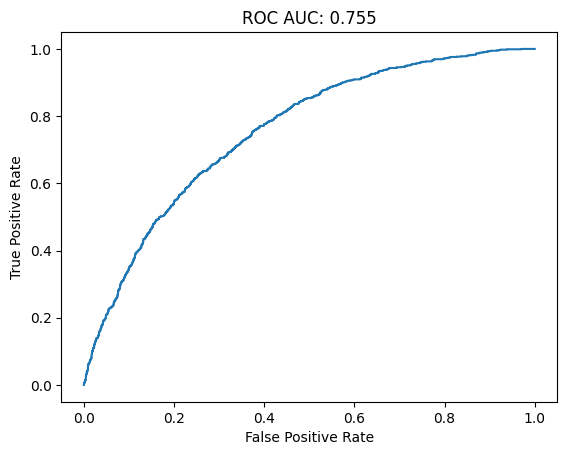

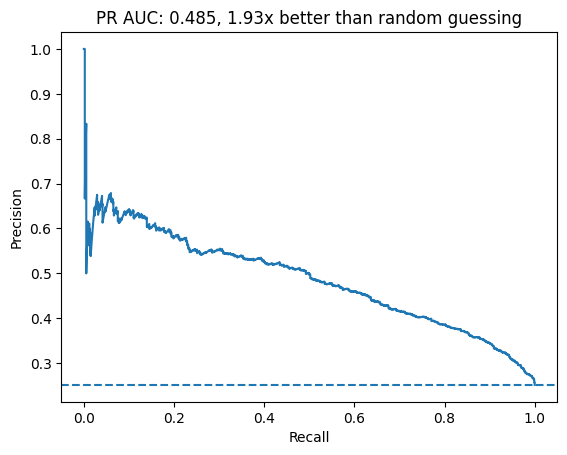

F1 score:  0.2704987320371936


In [43]:
actual_pos = df["score"] >= threshold
y_prob = y_test >= threshold
prevalence = np.sum(y_prob) / len(y_prob)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_prob, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# precision-recall curve
precision, recall, threshholds = precision_recall_curve(y_prob, y_pred)
roc_pr = auc(recall, precision)

plt.figure()
plt.title("PR AUC: " + str(round(roc_pr, 3)) + ", " + str(round(roc_pr / prevalence, 2)) + "x better than random guessing")
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axhline(prevalence, linestyle = "--")
plt.show()

# f1 score
f1 = f1_score(y_prob, y_pred >= threshold)
print("F1 score: ", f1)

## Feature importances

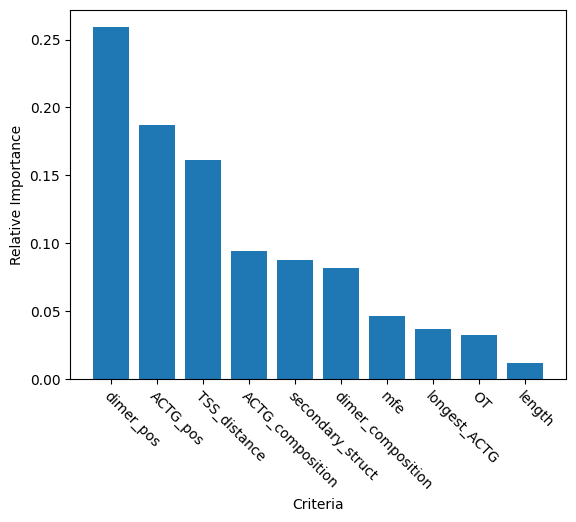

In [44]:
feature_imps = best_lgbm_reg.feature_importances_
sum_imps = feature_imps.sum()
imp_df = pd.DataFrame({
    "title": imp_title,
    "importance": feature_imps / sum_imps
})
grouped_imp_df = imp_df.groupby("title").sum().reset_index().sort_values(by = "importance", ascending = False)

plt.figure()
plt.bar(grouped_imp_df["title"], grouped_imp_df["importance"])
plt.xticks(rotation = -45, ha = "left", rotation_mode = "anchor")
plt.xlabel("Criteria")
plt.ylabel("Relative Importance")
plt.show()

# XGBoost Regression

## Fitting model

In [57]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(n_jobs = -1)

params = {
    "n_estimators": Integer(50, 500),
    "learning_rate": Real(0.001, 0.3, prior = "log-uniform"),
    "reg_lambda": Real(0.001, 100, prior = "log-uniform"),
    "reg_alpha": Real(0.001, 100, prior = "log-uniform"),
}

grid_xgb_reg = BayesSearchCV(xgb_reg, params, scoring = "r2", n_iter = 30, cv = 5, n_points = 2, verbose = 1)
_ = grid_xgb_reg.fit(X_train_scaled, y_train)
best_xgb_reg = grid_xgb_reg.best_estimator_
with open("models/XGB.pk1", "wb") as file:
    pickle.dump(best_xgb_reg, file)
    
with open("models/XGB.pk1", "rb") as file:
    best_xgb_reg = pickle.load(file)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:37:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:40:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:42:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:45:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:47:4

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:04:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:06:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:08:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:10:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:12:2

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:16:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:17:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:19:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:19:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:21:0

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:29:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:31:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:32:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:34:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:36:1

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:51:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:54:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:57:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:59:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:01:5

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:11:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:11:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:12:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:12:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:12:4

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:29:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:31:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:32:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:34:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:36:2

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:47:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:2

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:4

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:48:5

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:1

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:3

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:49:5

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:50:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:50:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:50:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:50:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:50:0

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:50:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:50:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:50:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:50:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:50:2

## Comparing model fit with test set

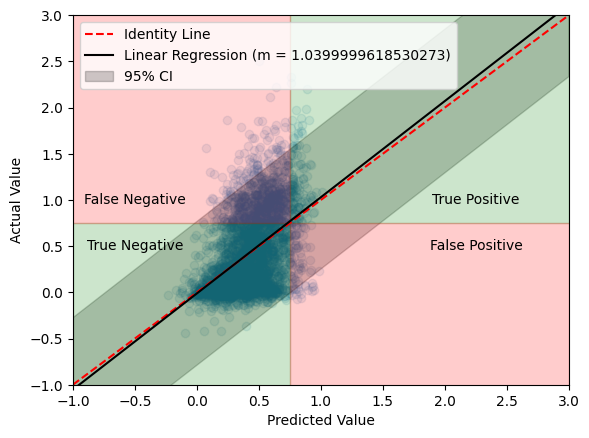

In [60]:
y_pred = best_xgb_reg.predict(X_test_scaled)

threshold = 0.75 # threshold by where we consider an sgRNA to be "highly active"
xmin = -1 # minimum on x axis
xmax = 3 # maximum on x axis
x = np.linspace(xmin, xmax, 100)

# fitting a linear regression to the data
lin_reg = LinearRegression()
lin_reg.fit(y_pred.reshape(-1, 1), y_test)
slope = lin_reg.coef_[0] # perfect fit, slope = 1
intercept = lin_reg.intercept_ # perfect fit, intercept = 0
y_pred_lr = lin_reg.predict(x.reshape(-1, 1))

# getting error bar for the linear regression
residuals = y_pred - lin_reg.predict(np.array(y_test).reshape(-1, 1))
std_res = np.std(residuals)
ci = 1.96 * std_res
lower_ci = y_pred_lr - ci
upper_ci = y_pred_lr + ci

xdist = (threshold - xmin) / (xmax - xmin) # distance along the x axis to place the location of threshold
plt.scatter(y_pred, y_test, alpha = 0.1)
plt.plot(x, x, color = 'red', linestyle = '--', label = 'Identity Line')
plt.plot(x, y_pred_lr, color = "black", label = f"Linear Regression (m = {round(slope, 2)})") # plotting linear regression
plt.fill_between(x, lower_ci, upper_ci, color = "black", alpha = 0.2, label = "95% CI")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.axhspan(-5, threshold, color = "green", alpha = 0.2, xmax = xdist) # true negative
plt.axhspan(threshold, 5, color = "green", alpha = 0.2, xmin = xdist) # true positive
plt.axhspan(-5, threshold, color = "red", alpha = 0.2, xmin = xdist) # false positive
plt.axhspan(threshold, 5, color = "red", alpha = 0.2, xmax = xdist) # false negative
plt.text(2.25, 1, "True Positive", horizontalalignment = "center", verticalalignment = "center")
plt.text(-0.5, 0.5, "True Negative", horizontalalignment = "center", verticalalignment = "center")
plt.text(2.25, 0.5, "False Positive", horizontalalignment = "center", verticalalignment = "center")
plt.text(-0.5, 1, "False Negative", horizontalalignment = "center", verticalalignment = "center")
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.legend()
plt.show()

## ROC curve (and other metrics)

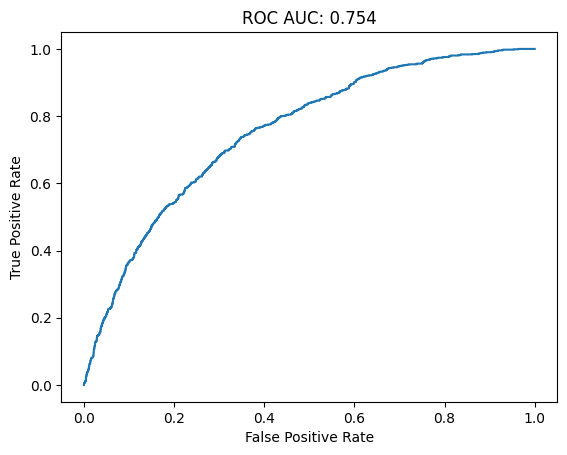

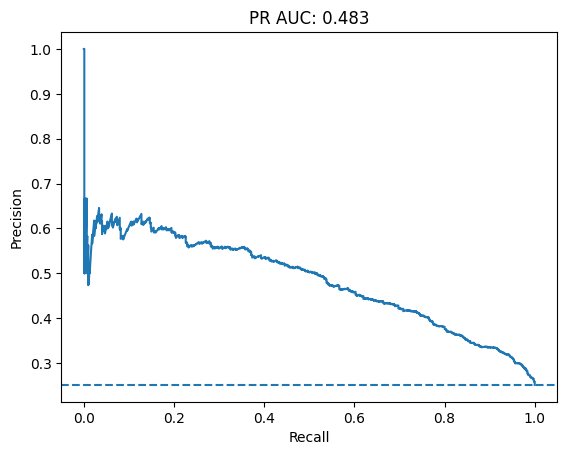

F1 score:  0.23247559893522626


In [61]:
y_prob = y_test >= threshold
prevalence = np.sum(y_prob) / len(y_prob)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_prob, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# precision-recall curve
precision, recall, threshholds = precision_recall_curve(y_prob, y_pred)
roc_pr = auc(recall, precision)

plt.figure()
plt.title("PR AUC: " + str(round(roc_pr, 3)))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axhline(prevalence, linestyle = "--")
plt.show()

# f1 score
f1 = f1_score(y_prob, y_pred >= threshold)
print("F1 score: ", f1)

# Elastic Net Linear Regression

## Fitting model

In [9]:
from sklearn.linear_model import ElasticNet

# elastic_net = ElasticNet(alpha = 1, l1_ratio = 0.5)
# elastic_net.fit(X_train_scaled, y_train)

# params = {
#     "alpha": Real(0.01, 100, prior = "log-uniform"),
#     "l1_ratio": Real(0, 1),
# }

# grid_elastic_net = BayesSearchCV(elastic_net, params, scoring = "r2", n_iter = 30, cv = 5, n_points = 2, verbose = 1)
# _ = grid_elastic_net.fit(X_train_scaled, y_train)
# best_elastic_net = grid_elastic_net.best_estimator_
# with open("models/elastic_net.pk1", "wb") as file:
#     pickle.dump(best_elastic_net, file)
    
with open("models/elastic_net.pk1", "rb") as file:
    best_elastic_net = pickle.load(file)

## Comparing model fit with test set

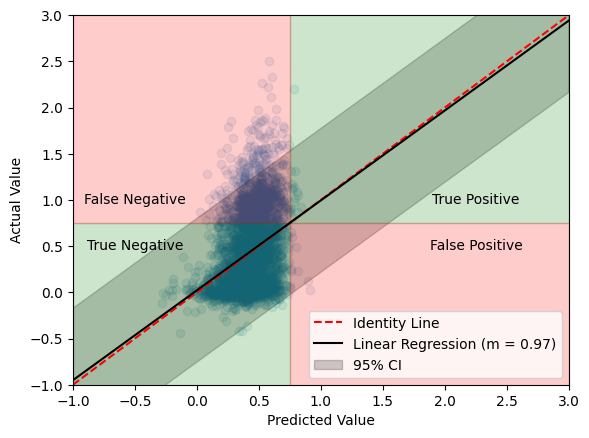

In [6]:
y_pred = best_elastic_net.predict(X_test_scaled)

threshold = 0.75 # threshold by where we consider an sgRNA to be "highly active"
xmin = -1 # minimum on x axis
xmax = 3 # maximum on x axis
x = np.linspace(xmin, xmax, 100)

# fitting a linear regression to the data
lin_reg = LinearRegression()
lin_reg.fit(y_pred.reshape(-1, 1), y_test)
slope = lin_reg.coef_[0] # perfect fit, slope = 1
intercept = lin_reg.intercept_ # perfect fit, intercept = 0
y_pred_lr = lin_reg.predict(x.reshape(-1, 1))

# getting error bar for the linear regression
residuals = y_pred - lin_reg.predict(np.array(y_test).reshape(-1, 1))
std_res = np.std(residuals)
ci = 1.96 * std_res
lower_ci = y_pred_lr - ci
upper_ci = y_pred_lr + ci

xdist = (threshold - xmin) / (xmax - xmin) # distance along the x axis to place the location of threshold
plt.scatter(y_pred, y_test, alpha = 0.1)
plt.plot(x, x, color = 'red', linestyle = '--', label = 'Identity Line')
plt.plot(x, y_pred_lr, color = "black", label = f"Linear Regression (m = {round(slope, 2)})") # plotting linear regression
plt.fill_between(x, lower_ci, upper_ci, color = "black", alpha = 0.2, label = "95% CI")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.axhspan(-5, threshold, color = "green", alpha = 0.2, xmax = xdist) # true negative
plt.axhspan(threshold, 5, color = "green", alpha = 0.2, xmin = xdist) # true positive
plt.axhspan(-5, threshold, color = "red", alpha = 0.2, xmin = xdist) # false positive
plt.axhspan(threshold, 5, color = "red", alpha = 0.2, xmax = xdist) # false negative
plt.text(2.25, 1, "True Positive", horizontalalignment = "center", verticalalignment = "center")
plt.text(-0.5, 0.5, "True Negative", horizontalalignment = "center", verticalalignment = "center")
plt.text(2.25, 0.5, "False Positive", horizontalalignment = "center", verticalalignment = "center")
plt.text(-0.5, 1, "False Negative", horizontalalignment = "center", verticalalignment = "center")
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.legend()
plt.show()

## ROC curve (and other metrics)

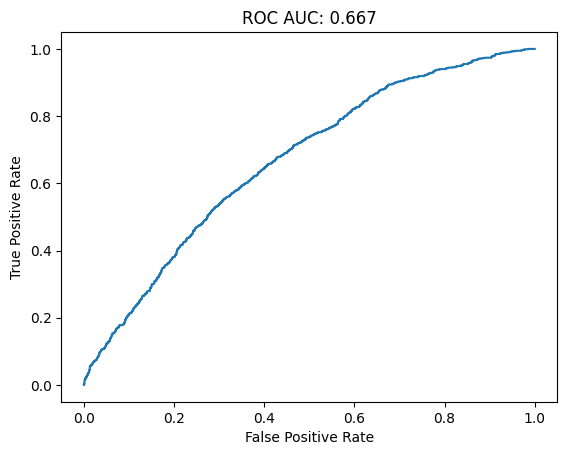

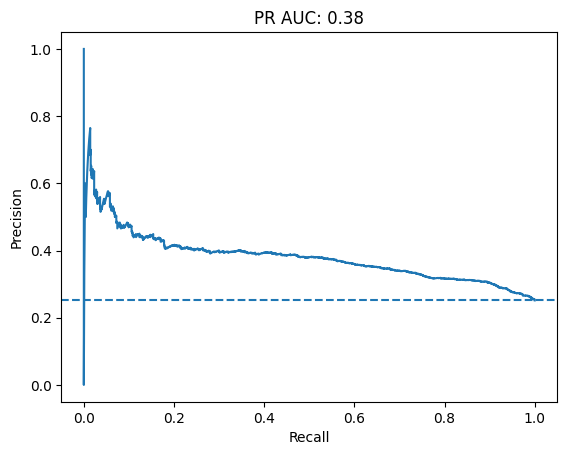

F1 score:  0.03400637619553666


In [7]:
y_prob = y_test >= threshold
prevalence = np.sum(y_prob) / len(y_prob)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_prob, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# precision-recall curve
precision, recall, threshholds = precision_recall_curve(y_prob, y_pred)
roc_pr = auc(recall, precision)

plt.figure()
plt.title("PR AUC: " + str(round(roc_pr, 3)))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axhline(prevalence, linestyle = "--")
plt.show()

# f1 score
f1 = f1_score(y_prob, y_pred >= threshold)
print("F1 score: ", f1)

# Deep Neural Network

## Fitting model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

train_set = TensorDataset(X_train_scaled, y_train)
test_set = TensorDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_set, batch_size = 32, shuffle = True)
test_loader = DataLoader(train_set, batch_size = 32, shuffle = True)

class RegModelNN(nn.Module):
    def __init(self, input_size, hidden_sizes, output_size, drop_level):
        super(RegModelNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0])
            nn.ReLU()
            nn.Dropout(drop_level)
            nn.Linear(hidden_sizes[0], hidden_sizes[1])
            nn.ReLU()
            nn.Dropout(drop_level)
            nn.Linear(hidden_sizes[1], output_size)
        )
    
    def forward(self, x):
        return self.network(x)
    
input_size = train_set.shape[1]
hidden_sizes = [128, 64]
output_size = 1

model = RegModelNN(input_size, hidden_sizes, output_size, 0.2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

## Training model

In [ ]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch + 1} / {num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

## Evaluating model

In [ ]:
model.eval()

with torch.no_grad():
    total_loss = 0
    
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        
    print(f"Test loss: {total_loss / len(test_loader):.4f}")